### Import Modules

In [56]:
import numpy as np
import gvar as gv
import lsqfit
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import time

sys.path.append("../")
from fitter import data_loader as dl
from fitter import bootstrapper as bs
from fitter import fitter as fit
from fitter import special_functions as sf

matplotlib.rcParams['figure.figsize'] = [10, 10]

In [147]:
reload(bs)
reload(dl)
reload(fit)
reload(sf)

<module 'fitter.special_functions' from '../fitter\special_functions.pyc'>

### Specify fit parameters

In [148]:
p_dict = {
    'order' : {
        'fit' : 'nlo', # 'nlo', 'nnlo', or 'nnnlo'
        'latt_spacing' : 2, # no order 1 term -- starts at 2
        'vol' : 8 # max 10
    }, 
    'bs_N' : 1,  # if 0, use full list
    'fit_type' : 'ma', #'ma', 'ma-taylor, 'xpt', or 'xpt-taylor'; also 'ma-old'
    'F2' : 'FKFpi', #'FKfpi', 'FpiFpi', 'FKFK'
    
    'use_prior' : False,
    'abbrs' : [u'a09m220', u'a09m310', u'a09m350', u'a09m400', u'a12m130',
           u'a12m220',  u'a12m220S', u'a12m310', u'a12m350',
           u'a12m400', u'a15m220', u'a15m310', u'a15m350', 'a15m400'],
    
    'make_plots' : True,
    'show_error_ellipses' : False,
    'show_bs_histograms' : False,
    
    'save_prior' : False,
    'save_results' : True,
}

### Do fit

In [149]:
t0 = time.time()

# Load data
data_loader = dl.data_loader()
fit_data = data_loader.get_fit_data()

# Get prior
prior = None
if p_dict['use_prior']:
    prior = data_loader.get_prior(p_dict['fit_type'])

# Make bootstrapper
bootstrapper = bs.bootstrapper(fit_data, prior=prior, order=p_dict['order'], F2=p_dict['F2'],
                               fit_type=p_dict['fit_type'], bs_N=p_dict['bs_N'], abbrs=p_dict['abbrs'])

if p_dict['make_plots']:
    data_loader.save_plots(
        bootstrapper.make_plots(
            show_error_ellipses=p_dict['show_error_ellipses'], 
            show_bootstrap_histograms=p_dict['show_bs_histograms']),
        output_filename=bootstrapper.fit_type+'_'+bootstrapper.order['fit']
    )
else:
    print bootstrapper
    
if p_dict['save_prior']:
    print 'Saving prior...'
    data_loader.save_prior(bootstrapper.create_prior_from_fit(), p_dict['fit_type'])
    
if p_dict['save_results']:
    data_loader.save_fit_info(bootstrapper)
    
    
t1 = time.time()

print "\nTotal time (s): ", t1 - t0, "\n"

Making fits...
100% complete Time (s):  0.919000148773
Compiling results...
Done.
Saving...

Total time (s):  4.91700005531 



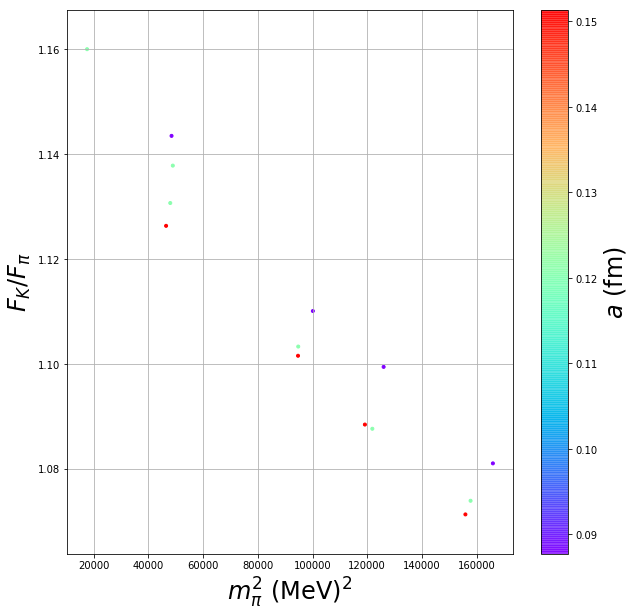

In [138]:
    def plot_parameters(self, xy_parameters, color_parameter=None,
                        xfcn=None, xlabel=None, yfcn=None, ylabel=None):

        # used to convert to phys units
        hbar_c = 197.327

        if xlabel is None:
            xlabel = self._fmt_key_as_latex(xy_parameters[0])
        if ylabel is None:
            ylabel = self._fmt_key_as_latex(xy_parameters[1])

        if xfcn is None:
            xfcn = lambda x : 1 * x
        if yfcn is None:
            yfcn = lambda y : 1 * y

        # Make plot data
        plot_data = {}
        myfcn = [xfcn, yfcn]
        for j, parameter in enumerate(xy_parameters):
            if parameter in ['FK/Fpi', 'FK / Fpi']:
                plot_data[j] = {abbr :  myfcn[j](self.fit_data[abbr]['FK'] /self.fit_data[abbr]['Fpi']) for abbr in self.abbrs}
            elif parameter in ['mpi', 'mju', 'mru', 'mk', 'mrs', 'mss', 'FK', 'Fpi']:
                # Convert to physical units

                plot_data[j] = {}
                for abbr in self.abbrs:
                    plot_data[j][abbr] = myfcn[j](self.fit_data[abbr][parameter] *hbar_c / (self.fit_data[abbr]['a']))           
            else:
                plot_data[j] = {abbr :  myfcn[j](self.fit_data[abbr][parameter]) for abbr in self.abbrs}


        # Get data for color coding graph
        if color_parameter is None:
            color_parameter = 'a'

        if color_parameter in ['a']:
            color_data = {abbr : np.repeat(self.fit_data[abbr]['a'], self.bs_N).ravel() for abbr in self.abbrs}
        elif color_parameter in ['L']:
            color_data = {abbr : np.repeat(gv.mean(self.fit_data[abbr][color_parameter]), self.bs_N).ravel() for abbr in self.abbrs}
        elif color_parameter == 'MpiL':
            color_data = {abbr : gv.mean(self.fit_data[abbr][color_parameter]).ravel() for abbr in self.abbrs}
        else:
            color_data = {abbr : gv.mean(self.fit_data[abbr][color_parameter]).ravel() for abbr in self.abbrs}

        # Color by lattice spacing/length
        cmap = matplotlib.cm.get_cmap('rainbow')
        min_max = lambda x : [np.min(x), np.max(x)]
        minimum, maximum = min_max(np.concatenate([gv.mean(color_data[abbr]) for abbr in self.abbrs]))
        norm = matplotlib.colors.Normalize(vmin=minimum, vmax=maximum)

        # Get scatter plot & color data
        x = np.zeros(self.bs_N * len(self.abbrs))
        y = np.zeros(self.bs_N * len(self.abbrs))
        z = np.zeros(self.bs_N * len(self.abbrs))
        for j, abbr in enumerate(self.abbrs):
            x[j*self.bs_N:(j+1)*self.bs_N] = gv.mean(plot_data[0][abbr])
            y[j*self.bs_N:(j+1)*self.bs_N] = gv.mean(plot_data[1][abbr])
            z[j*self.bs_N:(j+1)*self.bs_N] = gv.mean(color_data[abbr])

        # Plot data
        sc = plt.scatter(x, y, c=z, vmin=minimum, vmax=maximum,
                         cmap=cmap, rasterized=True, marker=".", alpha=100.0/self.bs_N)

        # Plot labels
        plt.grid()
        plt.xlabel(xlabel, fontsize = 24)
        plt.ylabel(ylabel, fontsize = 24)

        # Format colorbar
        color_bar = plt.colorbar(sc)
        color_bar.set_alpha(0.8)
        color_bar.draw_all()
        color_bar.set_label(self._fmt_key_as_latex(color_parameter), fontsize = 24)

        # Set xlim, ylim -- only works if xy_parameters[i] is a vector, not a scalar
        min_max = lambda x : [np.min(x), np.max(x)]
        try:
            xmin, xmax = min_max(np.concatenate([gv.mean(plot_data[0][abbr]) for abbr in self.abbrs]))
            ymin, ymax = min_max(np.concatenate([gv.mean(plot_data[1][abbr]) for abbr in self.abbrs]))
            xdelta = xmax - xmin
            ydelta = ymax - ymin
            plt.xlim(xmin-0.05*xdelta, xmax+0.05*xdelta) #xmin-0.05*xdelta
            #plt.ylim(ymin-0.05*ydelta, ymax+0.05*ydelta)
        except ValueError:
            pass

        fig = plt.gcf()
        plt.close()
        return fig
    
    squared = lambda x : x**2
    plot_parameters(bootstrapper, xy_parameters=['mpi', 'FK/Fpi'],
                    xfcn=squared, xlabel='$m_\pi^2$ (MeV)$^2$', color_parameter='a')

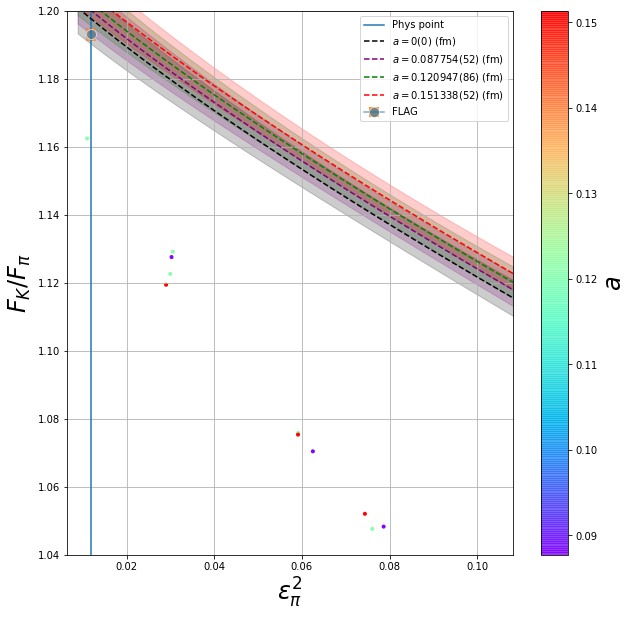

In [133]:
def plot_fit_vs_eps2pi(self):
        # used to convert to phys units
        hbar_c = 197.327

        plot_data = {
            0 :  {abbr : (self.fit_data[abbr]['mpi'] *hbar_c / self.fit_data[abbr]['a'])**2 /self.get_phys_point_data('lam2_chi') 
                              for abbr in self.abbrs},
            1 : {abbr : self.shift_fk_fpi_for_phys_mk(abbr) for abbr in self.abbrs}
        }

        color_data = {abbr : np.repeat(self.fit_data[abbr]['a'], self.bs_N).ravel() for abbr in self.abbrs}

        # Color by lattice spacing/length
        cmap = matplotlib.cm.get_cmap('rainbow')
        min_max = lambda x : [np.min(x), np.max(x)]
        minimum, maximum = min_max(np.concatenate([gv.mean(color_data[abbr]) for abbr in self.abbrs]))
        norm = matplotlib.colors.Normalize(vmin=minimum, vmax=maximum)

        # Get scatter plot & color data
        x = np.zeros(self.bs_N * len(self.abbrs))
        y = np.zeros(self.bs_N * len(self.abbrs))
        z = np.zeros(self.bs_N * len(self.abbrs))
        for j, abbr in enumerate(self.abbrs):
            x[j*self.bs_N:(j+1)*self.bs_N] = gv.mean(plot_data[0][abbr])
            y[j*self.bs_N:(j+1)*self.bs_N] = gv.mean(plot_data[1][abbr])
            z[j*self.bs_N:(j+1)*self.bs_N] = gv.mean(color_data[abbr])

        # Plot data
        sc = plt.scatter(x, y, c=z, vmin=minimum, vmax=maximum,
                         cmap=cmap, rasterized=True, marker=".", alpha=100.0/self.bs_N)

        
        if True:
            # Plot FLAG result
            x_phys = self.get_phys_point_data('mpi')**2 / self.get_phys_point_data('lam2_chi')
            plt.axvline(gv.mean(x_phys), label='Phys point')
            y_phys = self.get_phys_point_data('FK/Fpi')
            
            plt.errorbar(x=gv.mean(x_phys), xerr=0,
                         y=gv.mean(y_phys), yerr=gv.sdev(y_phys), label='FLAG',
                        color='C0', marker='o', capsize=0.0, mec='white', ms=10.0, alpha=0.6,
                             ecolor='C1', elinewidth=10.0)

            # Plot fit
            colors = ['black', 'purple', 'green', 'red']
            lattice_spacings = np.unique(self._make_fit_data(0)['a'])
            for j, a in enumerate(sorted(np.append([gv.gvar('0(0)')], lattice_spacings))):

                # Get the range of pion masses (in phys units)
                minimum = np.nanmin([np.nanmin(
                    np.sqrt([plot_data[0][abbr] *self.get_phys_point_data('lam2_chi') for abbr in self.abbrs])
                ) for abbr in self.abbrs])
                maximum = np.nanmax([np.nanmax(
                    np.sqrt([plot_data[0][abbr] *self.get_phys_point_data('lam2_chi')  for abbr in self.abbrs])
                ) for abbr in self.abbrs])
                minimum = gv.mean(minimum)
                maximum = gv.mean(maximum)
                delta = maximum - minimum

                x = np.linspace(np.max((minimum - 0.05*delta, 0)), maximum + 0.05*delta)

                # Get phys point data, substituting x-data and current 'a' in loop
                prepped_data = self.get_phys_point_data()
                prepped_data['mpi'] = x
                prepped_data['a'] = a

                # Covert m_pi -> (eps_pi)^2
                x = x**2/self.get_phys_point_data('lam2_chi')
                y = self.fk_fpi_fit_fcn(fit_data=prepped_data)

                pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
                plt.plot(pm(x, 0), pm(y, 0), '--', color=colors[j], label='$a=$%s (fm)'%(str(a)), rasterized=True)
                plt.fill_between(pm(x, 0), pm(y, -1), pm(y, 1), alpha=0.20, color=colors[j], rasterized=True)

        

        # Plot labels
        plt.legend()
        plt.grid()
        plt.xlabel('$\epsilon_\pi^2$', fontsize = 24)
        plt.ylabel('$F_K/F_\pi$', fontsize = 24)

        # Format colorbar
        color_bar = plt.colorbar(sc)
        color_bar.set_alpha(0.8)
        color_bar.draw_all()
        color_bar.set_label('$a$', fontsize = 24)

        # Set xlim, ylim -- only works if xy_parameters[i] is a vector, not a scalar
        min_max = lambda x : [np.min(x), np.max(x)]
        try:
            xmin, xmax = min_max(np.concatenate([gv.mean(plot_data[0][abbr]) for abbr in self.abbrs]))
            ymin, ymax = min_max(np.concatenate([gv.mean(plot_data[1][abbr]) for abbr in self.abbrs]))
            xdelta = xmax - xmin
            ydelta = ymax - ymin
            plt.xlim(xmin-0.05*xdelta, xmax+0.05*xdelta) #xmin-0.05*xdelta
            #plt.ylim(ymin-0.05*ydelta, ymax+0.05*ydelta)
            plt.ylim(1.04, 1.20)
        except ValueError:
            pass

        fig = plt.gcf()
        plt.close()
        return fig
    
plot_fit_vs_eps2pi(bootstrapper)

In [214]:
#bootstrapper.fits[0].show_plots()

In [34]:
#print bootstrapper.fits[0]